# Separate events in predictions

01.09.2022

Uso questo script per separare gli eventi nelle predictions, così da poter poi calcolare le metrics sulla instance segmentation.

Due idee:
- prima separare le classi e poi gli eventi
- sommare le preds delle classi, separare gli eventi e poi separare le classi

Una volta fatto, includere le funzioni in uno script normale di Python (.py) e usarle per la validation dei modelli (magari anche durante il training). A quel punto si potrà eliminare questo notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import glob
import os
import imageio
import napari
import matplotlib.pyplot as plt
import math
import seaborn as sns

import cc3d
from scipy import ndimage as ndi
from skimage.io import imsave
from scipy.ndimage.morphology import binary_dilation, binary_erosion

from in_out_tools import load_annotations_ids
from data_processing_tools import (get_argmax_segmentation_otsu,
                                   get_separated_events,
                                   get_smallest_event,
                                   merge_labels,
                                   renumber_labelled_mask,
                                   get_event_instances_class,
                                   get_processed_result
                                  )
from visualization_tools import get_discrete_cmap, get_annotations_contour
from metrics_tools import compute_iou, compute_inter_min, empty_marginal_frames

In [3]:
BASEDIR = os.path.abspath('')
BASEDIR

'C:\\Users\\dotti\\sparks_project\\sparks'

### Functions and global parameters

In [4]:
# configure Napari cmap
cmap = get_discrete_cmap(name='gray', lut=16)

# global parameters
PIXEL_SIZE = 0.2 # 1 pixel = 0.2 um x 0.2 um
global MIN_DIST_XY
MIN_DIST_XY = round(1.8 / PIXEL_SIZE) # min distance in space between sparks
TIME_FRAME = 6.8 # 1 frame = 6.8 ms
global MIN_DIST_T
MIN_DIST_T = round(20 / TIME_FRAME) # min distance in time between sparks

# parameters for puffs and waves CCs detection
connectivity = 26

# define minimal width of a detected wave (15 um)
global WAVE_MIN_WIDTH
WAVE_MIN_WIDTH = round(15/PIXEL_SIZE)

# parameters for spark peaks detection
radius = math.ceil(MIN_DIST_XY/2)
y,x = np.ogrid[-radius: radius+1, -radius: radius+1]
disk = x**2+y**2 <= radius**2
conn_mask = np.stack([disk]*(MIN_DIST_T), axis=0)

sigma = 3
ignore_frames_loss = 6 # frames ignored by loss fct during training

# maximal gap between two predicted puffs or waves that belong together
max_gap = 2 # i.e., 2 empty frames

In [5]:
classes = ['sparks', 'puffs', 'waves']

class_to_nb = {'sparks': 1,
               'puffs': 3,
               'waves': 2,
               'ignore_rois': 4
              }

## Load predictions

Load predictions from files generated when running the test function during training.

They are saved in `runs\<training_name>\predictions` and the filename template is `<training_name>_<movie_id>_<preds class/xs/ys/...>.tif`.

The epoch is not explicitly mentionned, but it depends on the last epoch of the last model that has been run.

In [6]:
# assuming these are the movie IDs whose predictions are available...
movie_ids = ["05","10","15","20","25","32","34","40","45"]

### Select training name to load

In [7]:
training_name = 'TEMP_new_annotated_peaks_physio'
inference_name = 'TEMP_new_annotated_peaks_physio_step=2'
epoch = 100000

### Configure input & output directory

In [8]:
training_dir = os.path.join("runs", training_name, "predictions")
preds_dir = os.path.join("trainings_validation", inference_name)
out_dir = os.path.join(preds_dir, "separated_events")
os.makedirs(out_dir, exist_ok=True)

### Load movies, annotations and predictions

In [9]:
### Load movies
xs_filenames = {movie_id: os.path.join(training_dir, training_name+"_"+movie_id+"_xs.tif") for movie_id in movie_ids}
xs = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in xs_filenames.items()}

### Load annotations
# Annotations used during training (from predictions folder)
# TODO: usare segmentation and instances che vengono dallo stesso posto

ys_filenames = {movie_id: os.path.join(training_dir, training_name+"_"+movie_id+"_ys.tif") for movie_id in movie_ids}
ys = {movie_id: np.asarray(imageio.volread(f)).astype('int') for movie_id, f in ys_filenames.items()}

### Load annotated event instances
dataset_dir =  os.path.join("..", "data", "sparks_dataset")
annotated_events = load_annotations_ids(data_folder=dataset_dir,
                                        ids=movie_ids,
                                        mask_names="event_label"
                                        )

### Load predictions
# Predictions created from selected model

sparks_filenames = {movie_id: os.path.join(preds_dir, f"{inference_name}_{epoch}_{movie_id}_sparks.tif") for movie_id in movie_ids}
puffs_filenames = {movie_id: os.path.join(preds_dir, f"{inference_name}_{epoch}_{movie_id}_puffs.tif") for movie_id in movie_ids}
waves_filenames = {movie_id: os.path.join(preds_dir, f"{inference_name}_{epoch}_{movie_id}_waves.tif") for movie_id in movie_ids}

sparks = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in sparks_filenames.items()}
puffs = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in puffs_filenames.items()}
waves = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in waves_filenames.items()}

#### Ensure that annotated event IDs are consecutive

Re-organise `annotated_events` dict to be indexed by `sample_id` and `event_type`...

In [10]:
ys_instances = {}
for sample_id in movie_ids:
    print(f"Processing movie {sample_id}")
    # re-organise annotated events in a dictionary
    ys_instances[sample_id] = get_event_instances_class(event_instances=annotated_events[sample_id],
                                                        class_labels=ys[sample_id],
                                                        shift_ids=True)

Processing movie 05
Processing movie 10
Processing movie 15
Processing movie 20
Processing movie 25
Processing movie 32
Processing movie 34
Processing movie 40
Processing movie 45


### TEMP: Get duration of shortest annotated puff

IDEA: per il momento uso questo come bound inferiore per i puffs detettati, più in là lo cambierò con un valore più adatto

In [11]:
global PUFF_MIN_T
PUFF_MIN_T = 9999

for sample_id in movie_ids:
    shortest_puff = get_smallest_event(events_mask=ys_instances[sample_id]['puffs'],
                                       event_type='puffs')

    if shortest_puff < PUFF_MIN_T:
        PUFF_MIN_T = shortest_puff

In [12]:
print("Shortest annotated puff duration:", PUFF_MIN_T)

Shortest annotated puff duration: 5


### TEMP: Get duration and width of shortest annotated spark

IDEA: per il momento uso questo come bound inferiore per i sparks detettati, più in là lo cambierò con un valore più adatto

In [13]:
global SPARK_MIN_T
SPARK_MIN_T = 9999
global SPARK_MIN_WIDTH
SPARK_MIN_WIDTH = 9999

for sample_id in movie_ids:
    shortest_spark, smallest_spark = get_smallest_event(events_mask=ys_instances[sample_id]['sparks'],
                                                        event_type='sparks')

    if shortest_spark < SPARK_MIN_T:
        SPARK_MIN_T = shortest_spark

    if smallest_spark < SPARK_MIN_WIDTH:
        SPARK_MIN_WIDTH = smallest_spark

In [14]:
print("Shortest annotated spark duration:", SPARK_MIN_T)
print("Smallest annotated spark width:", SPARK_MIN_WIDTH)

Shortest annotated spark duration: 3
Smallest annotated spark width: 3


# Separate events in all movies

### SEPARATE EVENTS USING OTSU THRESHOLD

In [15]:
# Dict indexed by movie IDs
preds_instances = {}
preds_segmentation = {}
sparks_loc = {}

for sample_id in movie_ids:
    print("Processing movie", sample_id, "...")
    
    sample = {'xs' : xs[sample_id],
              'ys' : ys[sample_id]}

    instances,segmentation,loc = get_processed_result(sparks=sparks[sample_id],
                                                      puffs=puffs[sample_id],
                                                      waves=waves[sample_id],
                                                      xs=xs[sample_id],
                                                      conn_mask=conn_mask,
                                                      connectivity=connectivity,
                                                      max_gap=max_gap,
                                                      sigma=sigma,
                                                      wave_min_width=WAVE_MIN_WIDTH,
                                                      puff_min_t=PUFF_MIN_T,
                                                      spark_min_t=SPARK_MIN_T,
                                                      spark_min_width=SPARK_MIN_WIDTH
                                                     )
    
    preds_instances[sample_id] = instances
    preds_segmentation[sample_id] = segmentation
    sparks_loc[sample_id] = loc

Processing movie 05 ...
	Events detection threshold: 0.7784512
	Number of sparks detected by nonmaxima suppression: 181
Processing movie 10 ...
	Events detection threshold: 0.7783982
	Number of sparks detected by nonmaxima suppression: 51
	Not all sparks were labelled, computing missing events...
	Number of sparks before correction: 51
	Number of sparks after correction: 52
Processing movie 15 ...
	Events detection threshold: 0.7812211
	Number of sparks detected by nonmaxima suppression: 28
	Not all sparks were labelled, computing missing events...
	Number of sparks before correction: 28
	Number of sparks after correction: 29
Processing movie 20 ...
	Events detection threshold: 0.78005457
	Number of sparks detected by nonmaxima suppression: 106
Processing movie 25 ...
	Events detection threshold: 0.7752061
	Number of sparks detected by nonmaxima suppression: 112
Processing movie 32 ...
	Events detection threshold: 0.7699964
	Number of sparks detected by nonmaxima suppression: 13
Proces

## Compute annotation-pred matches

For each pair (annotation, pred) compute their _score_ (IoU or IoMin) and then match annotations with predictions

Sparks are processed in a different way, by computing their peak distances

## Events postprocessing

- remove events that intersect ignore regions (add them to "ignored" dict) OK
- remove events in slices ignored by loss function TODO

#### Compute ignore mask for all movies

In [16]:
ignore_index = 4
ignore_masks = {movie_id: movie_ys==ignore_index for movie_id, movie_ys in ys.items()}

### Compute pairwise scores...

In [17]:
iou_scores = {}
iomin_scores = {}

for sample_id in movie_ids:
    print("Processing movie", sample_id, "...")
    
    # get number of annotated and predicted events
    n_ys_events = max([np.max(ys_instances[sample_id][event_type]) 
                       for event_type in ['sparks','puffs','waves']])
    
    n_preds_events = max([np.max(preds_instances[sample_id][event_type]) 
                          for event_type in ['sparks','puffs','waves']])
    
    # get score matrix for the two types of score: IoU and IoMin
    iou_scores[sample_id] = np.zeros((n_ys_events, n_preds_events))
    iomin_scores[sample_id] = np.zeros((n_ys_events, n_preds_events))

    # get ignore regions
    ignore_mask = ignore_masks[sample_id]

    # get matrices with all separated annotated and predicted events summed
    ys_all_events = sum(ys_instances[sample_id].values())
    preds_all_events = sum(preds_instances[sample_id].values())

    # compute pairwise values 
    for pred_id in range(1,n_preds_events+1):
        preds_roi = preds_all_events==pred_id
        # check that the ROI is not empty
        #assert preds_roi.any(), f"the predicted ROI n.{pred_id} is empty!"

        # check if ROI intersect at least one annotated event
        if np.count_nonzero(np.logical_and(ys_all_events, preds_roi)) != 0:

            for ys_id in range(1,n_ys_events+1):
                ys_roi = ys_all_events==ys_id
                # check that the ROI is not empty
                #assert ys_roi.any(), f"the annotated ROI n.{ys_roi} is empty!"

                # check if predicted and annotated ROIs intersect
                if np.count_nonzero(np.logical_and(ys_roi, preds_roi)) != 0:

                    # compute scores
                    iou_scores[sample_id][ys_id-1,pred_id-1] = compute_iou(ys_roi=ys_roi,
                                                            preds_roi=preds_roi,
                                                            ignore_mask=ignore_mask)

                    iomin_scores[sample_id][ys_id-1,pred_id-1] = compute_inter_min(ys_roi=ys_roi,
                                                                    preds_roi=preds_roi,
                                                                    ignore_mask=ignore_mask)

# assertions take ~45s to be computed...

Processing movie 05 ...
Processing movie 10 ...
Processing movie 15 ...
Processing movie 20 ...
Processing movie 25 ...
Processing movie 32 ...
Processing movie 34 ...
Processing movie 40 ...
Processing movie 45 ...


### Compute correspondences and get confusion matrix

In [18]:
# ID used for preds that are matched with an ignored event
matched_ignore_id = 9999

In [19]:
iou_t = 0.3
iomin_t = 0.5

#### Intersection over Union

In [20]:
iou_confusion_matrix = {}
iou_matched_events = {}
iou_ignored_preds = {}

print("Compute event correspondences:")

for sample_id in movie_ids:
    print("Processing movie", sample_id, "...")
    # dict indexed by predicted event indices, s.t. each entry is the 
    # list of annotated event ids that match the predicted event
    iou_matched_events[sample_id] = {}

    # confusion matrix cols and rows indices: {background, sparks, puffs, waves}
    iou_confusion_matrix[sample_id] = np.zeros((4,4))

    # count number of predicted events that are ignored
    iou_ignored_preds[sample_id] = 0

    for pred_class in classes:
        pred_class_id = class_to_nb[pred_class]
        # get ids of pred events in given class
        pred_ids = list(np.unique(preds_instances[sample_id][pred_class]))
        pred_ids.remove(0)

        # get ids of y events in same class
        y_ids = set(np.unique(ys_instances[sample_id][pred_class]))
        y_ids.remove(0)

        # get name of different classes
        other_classes = classes[:]
        other_classes.remove(pred_class)

        # get ignore regions
        ignore_mask = ignore_masks[sample_id]

        for pred_id in pred_ids:
            # get set of y_ids that are matched with pred_id (score > t):
            iou_matched_events[sample_id][pred_id] = np.where(iou_scores[sample_id][:,pred_id-1] >= iou_t)[0] + 1
            iou_matched_events[sample_id][pred_id] = set(iou_matched_events[sample_id][pred_id])

            # if at least one matched event is in same class, increase confusion matrix
            if (iou_matched_events[sample_id][pred_id] & y_ids): 
                iou_confusion_matrix[sample_id][pred_class_id,pred_class_id] += 1

            # else, if no y event is matched with this pred, check if it is ignored
            elif not iou_matched_events[sample_id][pred_id]:

                pred_roi = preds_instances[sample_id][pred_class] == pred_id
                pred_roi_size = np.count_nonzero(pred_roi)

                ignored_roi = np.logical_and(pred_roi, ignore_mask)
                ignored_roi_size = np.count_nonzero(ignored_roi)

                overlap = ignored_roi_size/pred_roi_size

                # if the overlap is not large enough, count pred as FP
                if overlap < iou_t:
                    iou_confusion_matrix[sample_id][0,pred_class_id] += 1
                # otherwise, mark pred as ignored event
                else:
                    iou_matched_events[sample_id][pred_id] = {matched_ignore_id}
                    iou_ignored_preds[sample_id] += 1

            # otherwise, try to match pred_id with the other classes
            else:
                for y_class in other_classes:
                    y_class_id = class_to_nb[y_class]
                    # get ids of y events in given class
                    y_other_ids = set(np.unique(ys_instances[sample_id][y_class]))
                    y_other_ids.remove(0)

                    if (iou_matched_events[sample_id][pred_id] & y_other_ids):
                        # if at least one matched event is in different class, increase confusion matrix
                        iou_confusion_matrix[sample_id][y_class_id,pred_class_id] += 1
                    
print()                    
# compute FN
print("Compute event FN:")
iou_unmatched_events = {}

for sample_id in movie_ids:
    print("Processing movie", sample_id, "...")
    # get list of all matched events
    y_matched_ids = set().union(*iou_matched_events[sample_id].values())
    iou_unmatched_events[sample_id] = set()

    for y_class in classes:
        y_class_id = class_to_nb[y_class]
        # get ids of annotated events in given class
        y_ids = set(np.unique(ys_instances[sample_id][y_class]))
        y_ids.remove(0)

        # get annotated events that are not matched with a pred
        y_unmatched_ids = y_ids.difference(y_matched_ids)
        n_unmatched = len(y_unmatched_ids)

        # update confusion matrix and list of unmatched events
        iou_confusion_matrix[sample_id][y_class_id,0] += n_unmatched
        iou_unmatched_events[sample_id] = iou_unmatched_events[sample_id].union(y_unmatched_ids)
        
# get confusion matrix of all summed events
iou_confusion_matrix_tot = sum(iou_confusion_matrix.values())

print()
print("Confusion matrix")
print(iou_confusion_matrix_tot)

Compute event correspondences:
Processing movie 05 ...
Processing movie 10 ...
Processing movie 15 ...
Processing movie 20 ...
Processing movie 25 ...
Processing movie 32 ...
Processing movie 34 ...
Processing movie 40 ...
Processing movie 45 ...

Compute event FN:
Processing movie 05 ...
Processing movie 10 ...
Processing movie 15 ...
Processing movie 20 ...
Processing movie 25 ...
Processing movie 32 ...
Processing movie 34 ...
Processing movie 40 ...
Processing movie 45 ...

Confusion matrix
[[  0. 418.   3. 136.]
 [186.  77.   0.   2.]
 [  2.   0.   5.   1.]
 [ 51.  12.   0.  12.]]


#### Intersection over Minimum

In [21]:
iomin_confusion_matrix = {}
iomin_matched_events = {}
iomin_ignored_preds = {}

print("Compute event correspondences:")

for sample_id in movie_ids:
    print("Processing movie", sample_id, "...")
    # dict indexed by predicted event indices, s.t. each entry is the 
    # list of annotated event ids that match the predicted event
    iomin_matched_events[sample_id] = {}

    # confusion matrix cols and rows indices: {background, sparks, puffs, waves}
    iomin_confusion_matrix[sample_id] = np.zeros((4,4))

    # count number of predicted events that are ignored
    iomin_ignored_preds[sample_id] = 0

    for pred_class in classes:
        pred_class_id = class_to_nb[pred_class]
        # get ids of pred events in given class
        pred_ids = list(np.unique(preds_instances[sample_id][pred_class]))
        pred_ids.remove(0)

        # get ids of y events in same class
        y_ids = set(np.unique(ys_instances[sample_id][pred_class]))
        y_ids.remove(0)

        # get name of different classes
        other_classes = classes[:]
        other_classes.remove(pred_class)

        # get ignore regions
        ignore_mask = ignore_masks[sample_id]

        for pred_id in pred_ids:
            # get set of y_ids that are matched with pred_id (score > t):
            iomin_matched_events[sample_id][pred_id] = np.where(iomin_scores[sample_id][:,pred_id-1] >= iomin_t)[0] + 1
            iomin_matched_events[sample_id][pred_id] = set(iomin_matched_events[sample_id][pred_id])

            # if at least one matched event is in same class, increase confusion matrix
            if (iomin_matched_events[sample_id][pred_id] & y_ids): 
                iomin_confusion_matrix[sample_id][pred_class_id,pred_class_id] += 1

            # else, if no y event is matched with this pred, check if it is ignored
            elif not iomin_matched_events[sample_id][pred_id]:

                pred_roi = preds_instances[sample_id][pred_class] == pred_id
                pred_roi_size = np.count_nonzero(pred_roi)

                ignored_roi = np.logical_and(pred_roi, ignore_mask)
                ignored_roi_size = np.count_nonzero(ignored_roi)

                overlap = ignored_roi_size/pred_roi_size

                # if the overlap is not large enough, count pred as FP
                if overlap < iomin_t:
                    iomin_confusion_matrix[sample_id][0,pred_class_id] += 1
                # otherwise, mark pred as ignored event
                else:
                    iomin_matched_events[sample_id][pred_id] = {matched_ignore_id}
                    iomin_ignored_preds[sample_id] += 1

            # otherwise, try to match pred_id with the other classes
            else:
                for y_class in other_classes:
                    y_class_id = class_to_nb[y_class]
                    # get ids of y events in given class
                    y_other_ids = set(np.unique(ys_instances[sample_id][y_class]))
                    y_other_ids.remove(0)

                    if (iomin_matched_events[sample_id][pred_id] & y_other_ids):
                        # if at least one matched event is in different class, increase confusion matrix
                        iomin_confusion_matrix[sample_id][y_class_id,pred_class_id] += 1
                        
                    
print()                    
# compute FN
print("Compute event FN:")
iomin_unmatched_events = {}

for sample_id in movie_ids:
    print("Processing movie", sample_id, "...")
    # get list of all matched events
    y_matched_ids = set().union(*iomin_matched_events[sample_id].values())
    iomin_unmatched_events[sample_id] = set()

    for y_class in classes:
        y_class_id = class_to_nb[y_class]
        # get ids of annotated events in given class
        y_ids = set(np.unique(ys_instances[sample_id][y_class]))
        y_ids.remove(0)

        # get annotated events that are not matched with a pred
        y_unmatched_ids = y_ids.difference(y_matched_ids)
        n_unmatched = len(y_unmatched_ids)

        # update confusion matrix and list of unmatched events
        iomin_confusion_matrix[sample_id][y_class_id,0] += n_unmatched
        iomin_unmatched_events[sample_id] = iomin_unmatched_events[sample_id].union(y_unmatched_ids)
        
        
# get confusion matrix of all summed events
iomin_confusion_matrix_tot = sum(iomin_confusion_matrix.values())

print()
print("Confusion matrix")
print(iomin_confusion_matrix_tot)

Compute event correspondences:
Processing movie 05 ...
Processing movie 10 ...
Processing movie 15 ...
Processing movie 20 ...
Processing movie 25 ...
Processing movie 32 ...
Processing movie 34 ...
Processing movie 40 ...
Processing movie 45 ...

Compute event FN:
Processing movie 05 ...
Processing movie 10 ...
Processing movie 15 ...
Processing movie 20 ...
Processing movie 25 ...
Processing movie 32 ...
Processing movie 34 ...
Processing movie 40 ...
Processing movie 45 ...

Confusion matrix
[[  0. 271.   1.  81.]
 [ 75. 160.   0.  12.]
 [  0.  22.   7.  23.]
 [ 14.  60.   0.  36.]]


## Visualise and analise results wrt to a given sample

Per capire se i risultati hanno davvero senso (ahimé)...

In [79]:
sample_id = '05'

In [80]:
# get paired events, ignored events and FP
matches = iomin_matched_events[sample_id]

# get list of FN
fn = iomin_unmatched_events[sample_id]

# get movies with separated events
sample_movie = xs[sample_id]
ys_movie = ys_instances[sample_id] # dict
preds_movie = preds_instances[sample_id] # dict

# get pairwise scores
scores = iomin_scores[sample_id]

In [51]:
# get number of events
n_ys_events = max([np.max(ys_instances[sample_id]['sparks']) 
                for event_type in ['sparks','puffs','waves']])
n_preds_events = max([np.max(preds_instances[sample_id][event_type]) 
                      for event_type in ['sparks','puffs','waves']])
n_ys_events, n_preds_events

(71, 184)

In [40]:
iomin_confusion_matrix[sample_id]

array([[ 0., 71.,  0., 29.],
       [ 5., 52.,  0.,  1.],
       [ 0.,  0.,  0.,  0.],
       [ 3., 14.,  0., 12.]])

In [41]:
viewer = napari.Viewer()

viewer.add_image(sample_movie, 
                 name='original movie', 
                 colormap=('colors',cmap)
                )

C:\Users\dotti\.conda\envs\sparks\lib\site-packages\napari\_qt\__init__.py:54: UserWarning: 

IMPORTANT:
You are using QT version 5.9.7, but version 5.15.6 was also found in your environment.
This usually happens when you 'conda install' something that also depends on PyQt
*after* you have pip installed napari (such as jupyter notebook).
You will likely run into problems and should create a fresh environment.
If you want to install conda packages into the same environment as napari,
please add conda-forge to your channels: https://conda-forge.org

  warn(message=warn_message)


<Image layer 'original movie' at 0x2087083a760>

In [70]:
viewer.add_labels(np.array(sum(preds_movie.values()), dtype=bool),
                  name='predicted events (all classes)',
                  opacity=0.5
                 )

#viewer.add_labels(sum(ys_movie.values()),
#                  name='annotated events (all classes)',
#                  opacity=0.5
#                 )

<Labels layer 'predicted events (all classes)' at 0x20bea43eee0>

In [45]:
puff_test = np.copy(preds_movie['puffs'])

viewer.add_labels(puff_test,
                  name='predicted puffs',
                  opacity=0.5
                 )

<Labels layer 'predicted puffs' at 0x1f5ec5fa640>

In [44]:
spark_test = np.copy(preds_movie['sparks'])

viewer.add_labels(spark_test.astype(bool),
                  name='predicted sparks',
                  opacity=0.5
                 )

<Labels layer 'predicted sparks' at 0x20a5cd37a30>

In [45]:
viewer.add_labels(ys_movie['sparks'].astype(bool),
                  name='annotated sparks',
                  opacity=0.5
                 )

<Labels layer 'annotated sparks' at 0x20a5ce0d2e0>

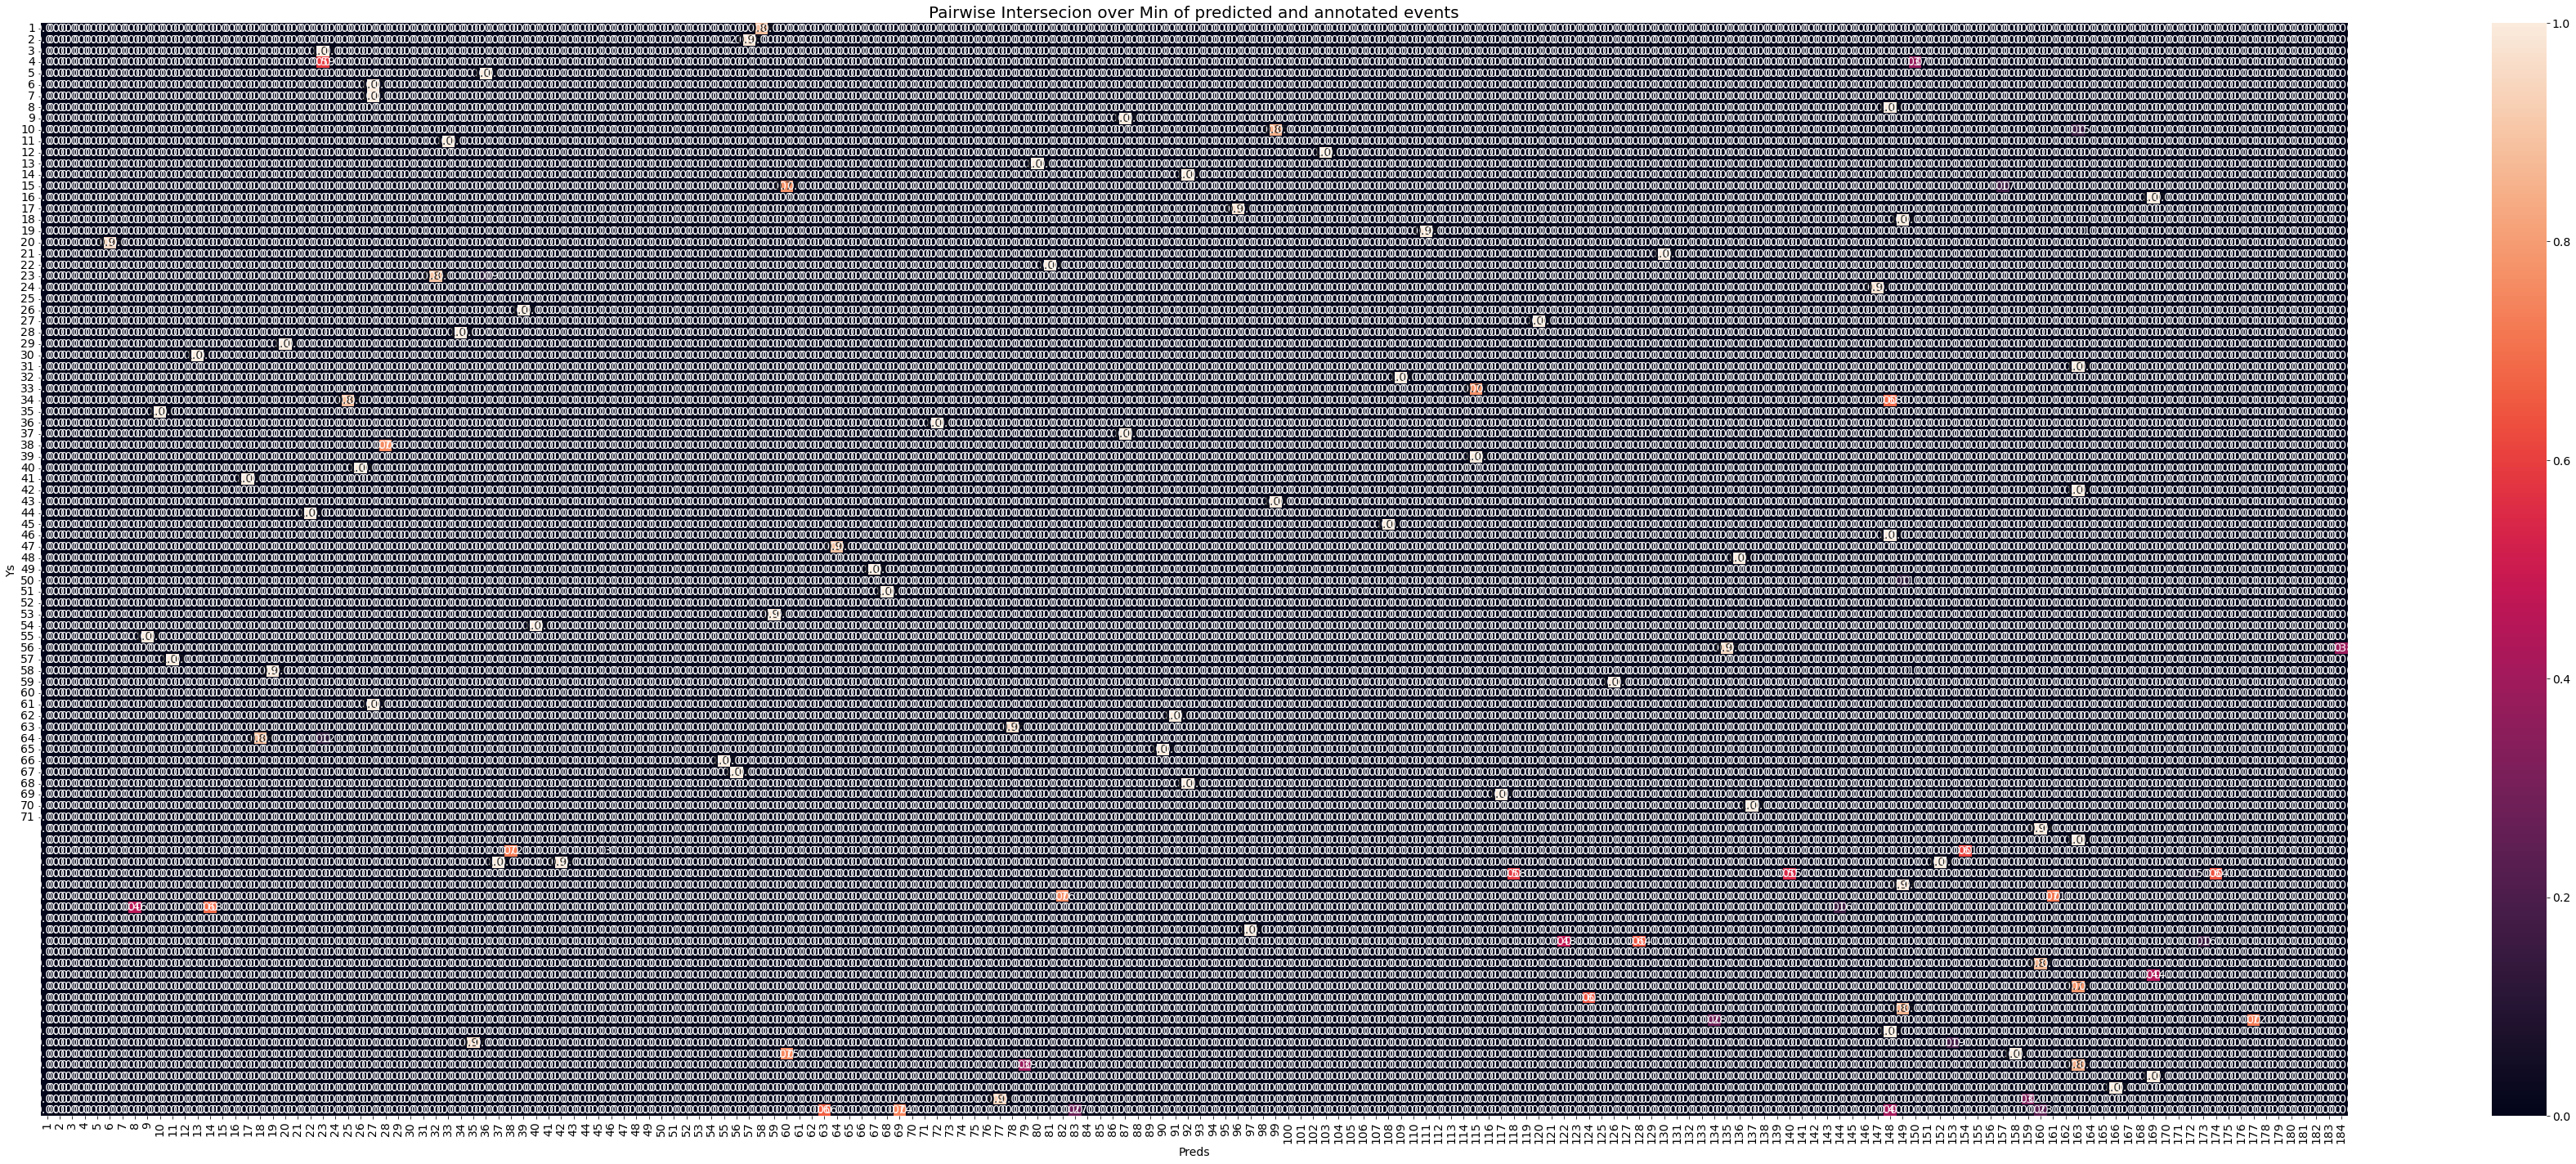

In [54]:
### visualise pairwise IoUs 

fig, ax = plt.subplots(1,1,figsize=(50,20))   
plt.rcParams.update({'font.size': 14})

sns.heatmap(scores, 
            annot=True, 
            fmt='.2f', 
            vmin=0, vmax=1, 
            yticklabels=np.arange(1,n_ys_events+1), 
            xticklabels=np.arange(1,n_preds_events+1),
            ax=ax
           )

ax.set_title('Pairwise Intersecion over Min of predicted and annotated events', 
             fontsize = 20) # title with fontsize 20
ax.set_ylabel('Ys') # x-axis label with fontsize 15
ax.set_xlabel('Preds') # y-axis label with fontsize
plt.tight_layout()
plt.savefig(os.path.join(out_dir,f"{sample_id}_pairwise_iomin.jpg"))

In [43]:
screenshot = viewer.screenshot()
#viewer.add_image(screenshot, rgb=True, name='screenshot')

In [44]:
from skimage.io import imsave

out_f = f"{sample_id}_puff_detected_as_spark_2.png"

imsave(out_f, screenshot)

In [81]:
print(fn)

{71, 80, 50, 83, 52, 85, 25, 60}


In [91]:
for event_id in fn:
    print(np.unique(np.where(ys_instances[sample_id]['sparks']==event_id)[0]))

[205 206 207]
[]
[122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140]
[]
[ 96  97  98  99 100]
[]
[307 308 309 310 311 312 313 314]
[ 7  8  9 10 11]


In [94]:
print(matches)

{1: set(), 2: set(), 3: set(), 4: set(), 5: set(), 6: {20}, 7: set(), 8: set(), 9: {55}, 10: {35}, 11: {57}, 12: set(), 13: {30}, 14: {79}, 15: set(), 16: set(), 17: {41}, 18: {64}, 19: {58}, 20: {29}, 21: set(), 22: {44}, 23: {3, 4}, 24: set(), 25: {34}, 26: {40}, 27: {61, 6, 7}, 28: {38}, 29: set(), 30: set(), 31: set(), 32: {23}, 33: {11}, 34: {28}, 35: {91}, 36: {5}, 37: {75}, 38: {74}, 39: {26}, 40: {54}, 41: set(), 42: {75}, 43: set(), 44: set(), 45: set(), 46: set(), 47: set(), 48: set(), 49: set(), 50: set(), 51: set(), 52: set(), 53: set(), 54: set(), 55: {66}, 56: {67}, 57: {2}, 58: {1}, 59: {53}, 60: {92, 15}, 61: set(), 62: set(), 63: {97}, 64: {47}, 65: set(), 66: set(), 67: {49}, 68: {51}, 69: {97}, 70: set(), 71: {9999}, 72: {36}, 73: set(), 74: set(), 75: {9999}, 76: set(), 77: {96}, 78: {63}, 79: set(), 80: {13}, 81: {22}, 82: {78}, 83: set(), 84: {9999}, 85: set(), 86: set(), 87: {9, 37}, 88: set(), 89: {9999}, 90: {65}, 91: {62}, 92: {68, 14}, 93: set(), 94: set(), 9

In [95]:
fp = [pred_id for pred_id, y_id in matches.items() if y_id == set()]

In [96]:
print(fp)

[1, 2, 3, 4, 5, 7, 8, 12, 15, 16, 21, 24, 29, 30, 31, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 61, 62, 65, 66, 70, 73, 74, 76, 79, 83, 85, 86, 88, 93, 94, 95, 98, 100, 101, 102, 104, 105, 106, 107, 110, 112, 113, 114, 116, 119, 121, 122, 123, 125, 127, 129, 131, 132, 133, 134, 138, 139, 141, 143, 144, 145, 146, 150, 151, 153, 155, 156, 157, 159, 162, 164, 165, 167, 168, 170, 171, 172, 173, 175, 176, 178, 179, 180, 181, 182, 183, 184]


# Compute segmentation-based metrics

## Concatenate segmentations and compute IoU

Metrics wrt to non-separated events !!

In [22]:
# compute IoU for each class
classes_iou = {}

# concatenate ignore masks
ignore_concat = np.concatenate([m for m in ignore_masks.values()],
                               axis=0)

for event_type in classes:
    # create list to concatenate all movies
    updated_preds = []
    updated_ys = []
    
    for sample_id in movie_ids:
        updated_preds.append(empty_marginal_frames(
                                video=preds_segmentation[sample_id][event_type],
                                n_frames=ignore_frames_loss))

        updated_ys.append(empty_marginal_frames(
                                video=ys[sample_id]==class_to_nb[event_type],
                                n_frames=ignore_frames_loss))
        
    preds_concat = np.concatenate(updated_preds, axis=0)
    ys_concat = np.concatenate(updated_ys, axis=0)
    
    classes_iou[event_type] = compute_iou(ys_roi=ys_concat,
                                          preds_roi=preds_concat,
                                          ignore_mask=ignore_concat) 

In [23]:
classes_iou

{'sparks': 0.1526836407298092,
 'puffs': 0.235108431321265,
 'waves': 0.3631125507651648}

In [24]:
#movies_concat = np.concatenate([m for m in xs.values()], axis=0)

#viewer = napari.Viewer()
#viewer.add_image(movies_concat, 
#                 name='concatenated movie', 
#                 colormap=('colors',cmap)
#                )

#viewer.add_labels(preds_sparks_concat,
#                  name='predicted concatenated sparks segmentation',
#                  opacity=0.5
#                 )

#viewer.add_labels(ys_sparks_concat,
#                  name='annotated concatenated sparks segmentation',
#                  opacity=0.5
#                 )

## Visualise confusion matrix

In [25]:
plt.rcParams.update({'font.size': 24})

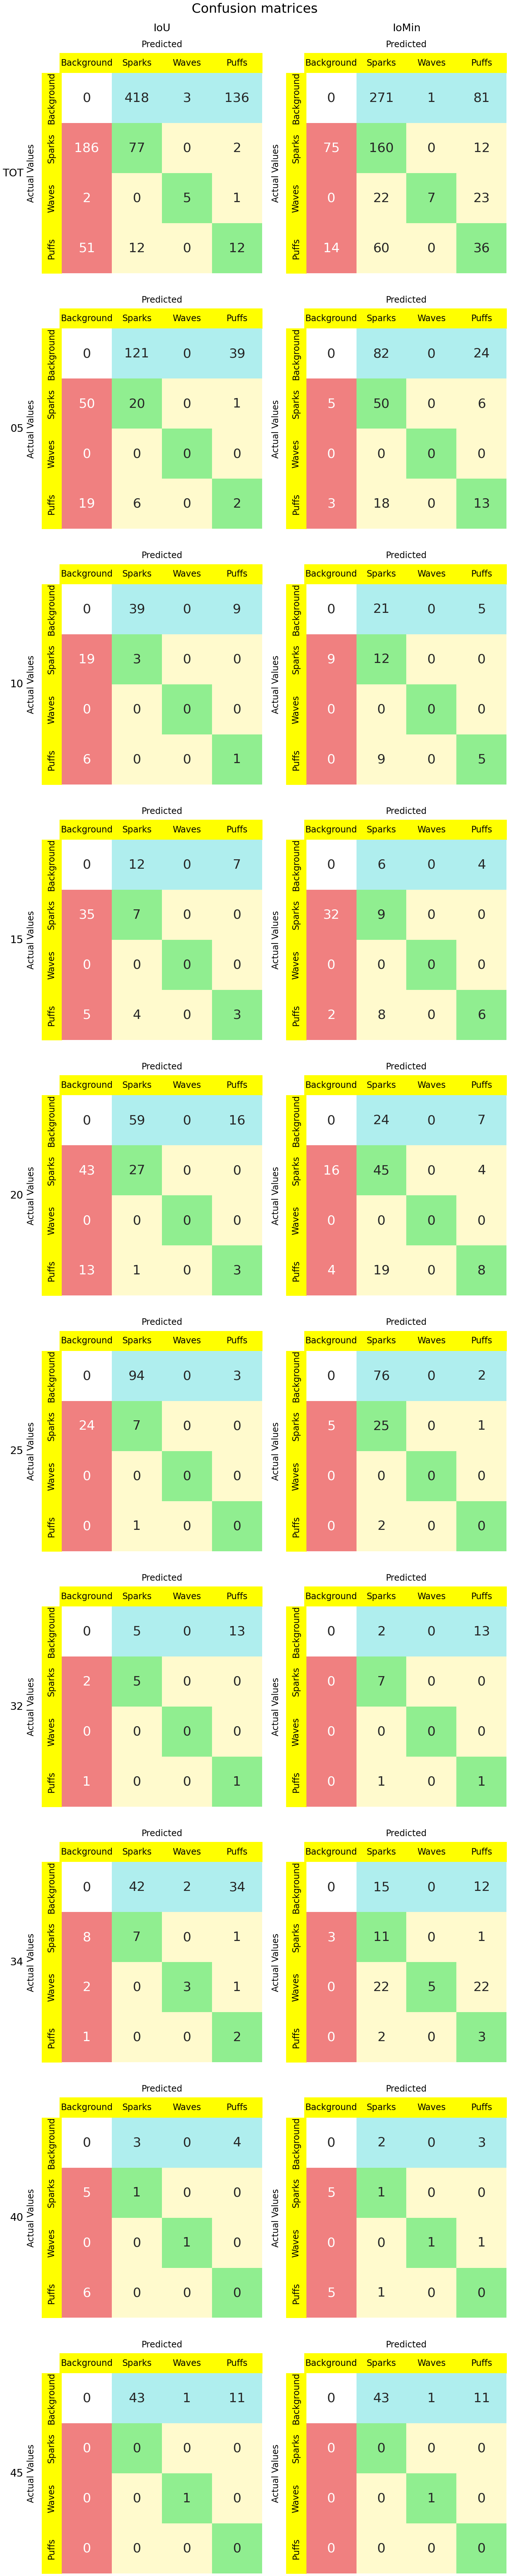

In [26]:
n_rows = (len(movie_ids)+1)#*2
n_cols = 2
num_plots = n_rows*n_cols

pad = 5 # in points

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 100))

cols = ['IoU', 'IoMin']
tick_labels = ['Background', 'Sparks', 'Waves', 'Puffs']

for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1.2), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')



for ax, row in zip(axs[:,0], ['TOT']+movie_ids):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

fig.suptitle("Confusion matrices", fontsize=36, y=1)


# configure heatmap background
colors = sns.color_palette(['white',
                            'lightcoral',
                            'paleturquoise',
                            'lemonchiffon',
                            'lightgreen'], as_cmap=True)
colored_bg = [[0,2,2,2],
                [1,4,3,3],
                [1,3,4,3],
                [1,3,3,4]]

# Get array with confusion matrices to be plotted
cm_array = np.concatenate(([[iou_confusion_matrix_tot, iomin_confusion_matrix_tot]],
               [[iou_confusion_matrix[sample_id], iomin_confusion_matrix[sample_id]]
                for sample_id in movie_ids]), axis=0)

for row_id in range(n_rows):
    for col_id in range(n_cols):
        cm = cm_array[row_id, col_id].astype(int).astype(str)

        ax = axs[row_id, col_id]
        sns.heatmap(data=colored_bg, 
                    cmap=colors,
                    annot=cm,
                    fmt='', 
                    annot_kws={'fontsize': 36}, 
                    cbar=False, 
                    square=True,
                    ax = ax
                   )

        ax.tick_params(length=0, labeltop=True, labelbottom=False)
        ax.tick_params(axis='both', which='major', pad=16)

        ax.set_xlabel('Predicted', labelpad=32)
        ax.xaxis.set_label_position('top')
        ax.set_xticklabels(tick_labels)
        ax.add_patch(plt.Rectangle((-0.01, 1), 1.01, 0.1, color='yellow', clip_on=False, zorder=0, transform=ax.transAxes))

        ax.set_ylabel('Actual Values', labelpad=32)
        ax.set_yticklabels(tick_labels, rotation=90, va='center')
        ax.add_patch(plt.Rectangle((0, 0), -0.1, 1, color='yellow', clip_on=False, zorder=0, transform=ax.transAxes))

#plt.subplots_adjust(hspace=0.005, wspace=0.)
#plt.subplots_adjust(hspace=0.1, wspace=0.1, top=0.9, left=0.05, right=0.95)
#fig.subplots_adjust(left=0.15, top=0.95)
fig.subplots_adjust(wspace=1.5)
plt.tight_layout()
plt.savefig(os.path.join(out_dir,"all_confusion_matrices.png"))
plt.show()

### TEMP (MIDTERM): uso questo codice per salvare un'immagine delle preds con Napari

### TEMP (MIDTERM): uso questo codice per salvare immagini di esempi di frames delle preds con Napari

### TEMP (MIDTERM): reasons for choosing IoMin over IoU

Ex: movie 10

- pred #3, y #10: IoU = 0.1 and IoMin = 1 <- correct pair
- pred #2, y #9: IoU = 0 and IoMin = 1 <- correct pair
- (pred #43, y #19: IoU = 0 and IoMin = 0.3 <- wrong pair)